# Convolution - Classification de sentiments

    

In this notebook I will
- search a good model for the classification task.
- evaluate the quality of the best model

In [1]:
import logging
import torchtext.datasets as datasets
import torchtext.data as data
import torchtext
import torch.nn as nn
import torch.nn.functional as F

import nltk
import torch

import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import pandas as pd

from spacy.lang.en.stop_words import STOP_WORDS

from collections import Counter

MODEL_PATH = 'models/parallel_text_clf'

In [40]:
DATA_DIR="/home/samutamm/Documents/Study/Sorbonne/AS/TME/data"

DATASET_DIR="%s/data" % DATA_DIR
VECTORS_DIR="%s/vectors" % DATA_DIR

torch.cuda.set_device(0)
device = torch.device('cuda')

# text
TEXT=data.Field(lower=True,include_lengths=False,batch_first=True)# stop_words=list(STOP_WORDS))
LABEL = data.Field(sequential=False, is_target=True)

# make splits for data
train, val, test = datasets.sst.SST.splits(TEXT, LABEL,root=DATASET_DIR)

# Use the vocabulary
wordemb = torchtext.vocab.GloVe("6B", dim=100, cache=VECTORS_DIR)
# Build the vocabularies
# for labels, we use special_first to False so <unk> is last
# (to discard it)
TEXT.build_vocab(train, vectors=wordemb)
LABEL.build_vocab(train, specials_first=False)
train_iter, val_iter, test_iter = data.BucketIterator.splits(
(train, val, test), batch_size=10, device=device)

nn_embeddings = nn.Embedding.from_pretrained(TEXT.vocab.vectors).to(device=device)

## Build model

In [5]:
class SentimentConv(nn.Module):
    """
    N convolutional layers in parallel. The output of each conv layer is concatened to fully-connected layer.
    """

    def __init__(self, 
                 filter_N=64, 
                 kernels = [3,4], 
                 dropout_ratio=0.5, 
                 embedding_dim = 100, 
                 outputs=2):
        super().__init__()
        
        self.convs = nn.ModuleList(
            [nn.Conv2d(in_channels=1,out_channels=filter_N,kernel_size=(k, embedding_dim)) for k in kernels]
        )
        self.dropout = nn.Dropout(dropout_ratio)
        self.classifier = nn.Sequential(
            nn.Linear(filter_N * len(kernels), outputs)
        )

    def forward(self, input):
        conveds = [torch.relu(conv(input.unsqueeze(1)).squeeze(3)) for conv in self.convs]
        pooleds = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conveds]
        
        output = self.dropout(torch.cat(pooleds, dim=1))
        output = self.classifier(output)
        return output

Then define all helper functions needed.

In [6]:
def accuracy(output, target):
    output = torch.sigmoid(output)
    if output.shape[1] > 1:
        y_pred = output.argmax(1)
    else:
        y_pred = torch.round(output).long()
    target = target.view(target.shape[0],)
    return (y_pred == target).sum().cpu().numpy(), target.shape[0]

def add_padding(text, pad_size=52):
    length = text.shape[1]
    if length < pad_size:
        padding = torch.zeros((text.shape[0], pad_size - length), device=device).long()
        padded_text = torch.cat((text, padding), dim=1)
    else:
        padded_text = text
    return padded_text

def training_epoch(model,train_iter,embeds, optimizer, 
                   reshape_target = None, 
                   pad_size=52):
    losses = []
    correct = 0
    examples = 0
    model.train()
    # Epoch
    for i, (text, target) in enumerate(train_iter):
        if reshape_target:
            target = reshape_target(target).long()
        transformed_text = embeds(add_padding(text, pad_size=pad_size))
        output = model(transformed_text)
                
        loss = criterion(output, target.view(target.shape[0],))
        
        # Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate loss
        if i % 2 == 0: 
            with torch.no_grad():
                losses.append(loss.cpu().numpy())
                corr, tot = accuracy(output, target)
                correct += corr
                examples += tot
    return np.mean(losses), correct / examples

def evaluate(model, embeds, iterable, pad_size=52, reshape_target = None):
    model.eval()
    with torch.no_grad():
        correct = 0.0
        examples = 0
        for i, (text, target) in enumerate(iterable):
            if reshape_target:
                target = reshape_target(target).long()
            transformed_text = embeds(add_padding(text, pad_size=pad_size))
            output = model(transformed_text)
            
            corr, tot = accuracy(output, target)
            correct += corr
            examples += tot

    #import pdb; pdb.set_trace()
    return correct / examples

def plot_results(epoch_losses, test_accuracys, train_accuracys):
    test_accuracys = np.array(test_accuracys)
    train_accuracys = np.array(train_accuracys)

    plt.figure()
    plt.plot(epoch_losses)
    plt.title('Loss')
    plt.figure()
    plt.plot(train_accuracys[:,0], train_accuracys[:,1], label="train")
    plt.plot(test_accuracys[:,0], test_accuracys[:,1], label="test")
    plt.title('Accuracy')
    plt.legend()
    plt.show()

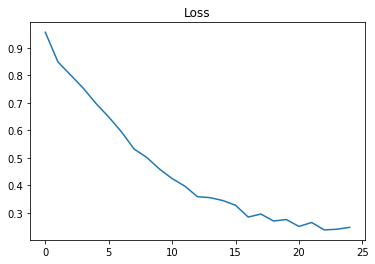

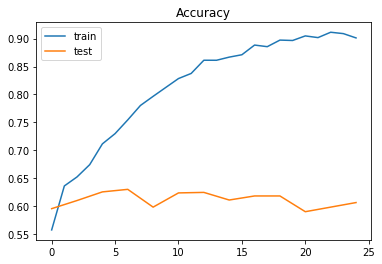

In [8]:
DIM_SIZE = TEXT.vocab.vectors.shape[1]

model = SentimentConv(filter_N=100,kernels=[3,4,5],embedding_dim=DIM_SIZE, outputs=3).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

reshape_target = lambda t : t.view(t.shape[0], 1)

epoch_losses = []
train_accuracys = []
test_accuracys = []
for epoch in range(25):
    if epoch % 2 == 0:
        #print(epoch)
        pass
    
    train_loss, train_acc = training_epoch(model, 
                                           train_iter, 
                                           nn_embeddings, 
                                           optimizer,
                                           reshape_target = reshape_target)
    train_accuracys.append((epoch, train_acc))
    epoch_losses.append(train_loss)
    
    # Test
    if epoch % 2 == 0:
        test_accuracys.append((epoch, evaluate(model, 
                                               nn_embeddings, 
                                               val_iter, 
                                               reshape_target = reshape_target)))

plot_results(epoch_losses, test_accuracys, train_accuracys)

torch.save(model.state_dict(), MODEL_PATH)

With the model of parallel convolutions, the accuracy is at maximum 0.62.

## Binary classification
The problem seems to be difficult : is it cause of ambigious classes ? I will try with only positive and negative classes.

In [23]:
def filter_labels(dataset):
    labels = np.array([ex.label for ex in dataset.examples])
    filtered_label_idx = np.where(np.logical_or(labels == 'positive', labels == 'negative'))[0]
    dataset.examples = [ex for i,ex in enumerate(dataset.examples) if i in filtered_label_idx]
    return dataset

In [232]:
train_bin = filter_labels(train)
val_bin = filter_labels(val)
test_bin = filter_labels(test)

wordemb = torchtext.vocab.GloVe("6B", dim=100, cache=VECTORS_DIR)

TEXT.build_vocab(train_bin, vectors=wordemb)
LABEL.build_vocab(train_bin, specials_first=False)
train_bin_iter, val_bin_iter, test_bin_iter = data.BucketIterator.splits(
(train_bin, val_bin, test_bin), batch_size=10, device=device)

0
2
4
6
8
10
12
14
16
18


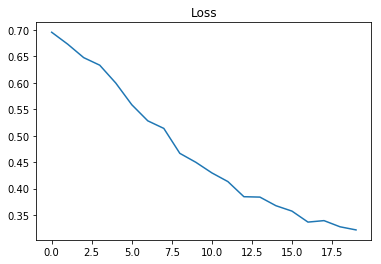

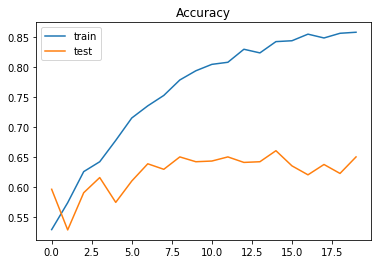

In [98]:
model = SentimentConv(filter_N=20,kernels=[2,3,4,5], outputs=1).to(device=device)
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_losses = []
train_accuracys = []
test_accuracys = []
for epoch in range(20):
    if epoch % 2 == 0:
        print(epoch)
    
    train_loss, train_acc = training_epoch(train_bin_iter, model, optimizer, reshape_target=True)
    train_accuracys.append((epoch, train_acc))
    epoch_losses.append(train_loss)
    
    # Test
    if epoch % 1 == 0:
        test_accuracys.append((epoch, evaluate(model, val_bin_iter)))

plot_results(epoch_losses, test_accuracys, train_accuracys)

With the only two classes, the accuracy is at maximum 0.65. It is not much easier than with 3 classes, so let's continue with all three classes.

## Sequential model
Might the perfomance rise if we put the convolutions in sequence. This model is not general (there are hard coded dimensions), since this is only small test.

In [309]:
class SqueezeConv(nn.Module):
    def forward(self, input):
        return input.squeeze(3)
    
class UnsqueezeConv(nn.Module):
    def forward(self, input):
        return input.unsqueeze(1)

class SeqSentimentConv(nn.Module):
    """
    """

    def __init__(self, 
                 filters_n=[64, 8], 
                 kernels_sizes = [3, 3], 
                 dropout_ratio=0.5, 
                 embedding_dim = 100, 
                 outputs=2):
        super().__init__()
        
        modules = [nn.Conv2d(in_channels=1,
                             out_channels=filters_n[0],
                             kernel_size=(kernels_sizes[0], embedding_dim))]
        modules.append(nn.ReLU())
        modules.append(SqueezeConv())
        modules.append(nn.MaxPool1d(2, stride=2))
        
        modules.append(UnsqueezeConv())
        modules.append(nn.Conv2d(in_channels=1,
                             out_channels=filters_n[1],
                             kernel_size=(kernels_sizes[1], 1394)))
        modules.append(nn.ReLU())
        modules.append(SqueezeConv())
        modules.append(nn.MaxPool1d(2, stride=2))
        
        self.seq_conv = nn.Sequential(*modules)
        self.dropout = nn.Dropout(dropout_ratio)
        self.classifier = nn.Sequential(
            nn.Linear(248, outputs)
        )

    def forward(self, input):
        batch_size = input.shape[0]
        output = self.seq_conv(input.unsqueeze(1))
        
        output = output.view(batch_size, -1)
        output = self.dropout(output)
        output = self.classifier(output)
        return output

50
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28


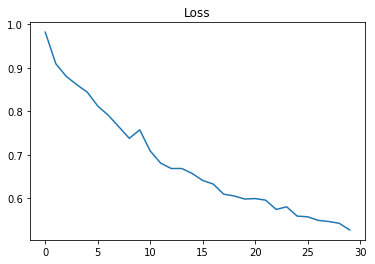

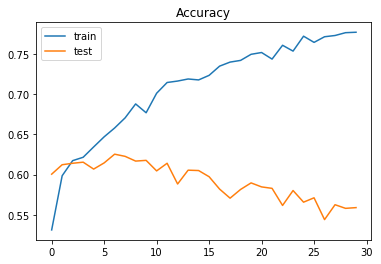

In [286]:
DIM_SIZE = TEXT.vocab.vectors.shape[1]
print(DIM_SIZE)
model = SeqSentimentConv(embedding_dim=DIM_SIZE, outputs=3).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch_losses = []
train_accuracys = []
test_accuracys = []
for epoch in range(30):
    if epoch % 2 == 0:
        print(epoch)
    #model,train_iter,embeds, optimizer, reshape_target = False, pad_size=52
    train_loss, train_acc = training_epoch(model, train_iter, nn_embeddings, optimizer)
    train_accuracys.append((epoch, train_acc))
    epoch_losses.append(train_loss)
    
    # Test
    if epoch % 1 == 0:
        test_accuracys.append((epoch, evaluate(model, nn_embeddings,test_iter)))

plot_results(epoch_losses, test_accuracys, train_accuracys)

In [221]:
evaluate(model, test_iter)

0.5660633484162896

The performance is poorer than with the first parallel model. Let's keep parallel model.

## Try different dataset

In [223]:
from torchtext import datasets

In [287]:
wordemb = torchtext.vocab.GloVe("6B", dim=100, cache=VECTORS_DIR)

IMDB_TEXT = data.Field(tokenize='spacy',lower=True,include_lengths=False,batch_first=True)
IMDB_LABEL = data.Field(dtype=torch.float, is_target=True)

train_data, test_data = datasets.IMDB.splits(IMDB_TEXT, IMDB_LABEL)

train_data, valid_data = train_data.split()

IMDB_TEXT.build_vocab(train_data, vectors=wordemb)
IMDB_LABEL.build_vocab(train_data, specials_first=False)

train_iter_imdb, val_iter_imdb, test_iter_imdb = data.BucketIterator.splits(
(train_data, valid_data, test_data), batch_size=20, device=device)

nn_embeddings_imdb = nn.Embedding.from_pretrained(IMDB_TEXT.vocab.vectors).to(device=device)

100
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28


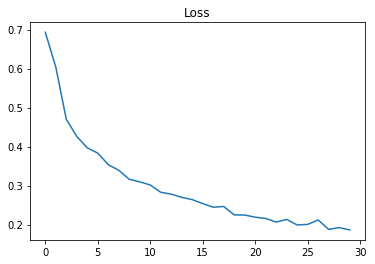

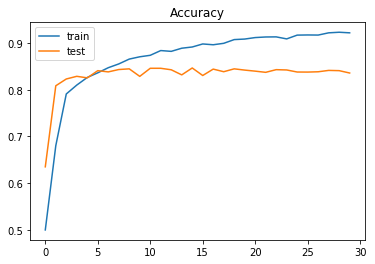

In [351]:
DIM_SIZE = IMDB_TEXT.vocab.vectors.shape[1]
PAD_SIZE = 2790
print(DIM_SIZE)
model = SeqSentimentConv(embedding_dim=DIM_SIZE, outputs=2).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch_losses = []
train_accuracys = []
test_accuracys = []
for epoch in range(30):
    if epoch % 2 == 0:
        print(epoch)
    
    train_loss, train_acc = training_epoch(model,train_iter_imdb, nn_embeddings_imdb, optimizer, pad_size=PAD_SIZE)
    train_accuracys.append((epoch, train_acc))
    epoch_losses.append(train_loss)
    
    # Test
    if epoch % 1 == 0:
        test_accuracys.append((epoch, evaluate(model, nn_embeddings_imdb,val_iter_imdb, pad_size=PAD_SIZE)))

plot_results(epoch_losses, test_accuracys, train_accuracys)

This experiment shows that the problem itself is difficult : my models work better with bigger dataset, that contains more information for classification.

# Evaluation qualitative
So as the parallel model (the first one in this notebook) is superior, we will evalute the quality of that one.

Let's look
- Gradients of model
- Activations of different input

## Gradients
What kind of gradients our model will calculate for different inputs.

In [150]:
DIM_SIZE = TEXT.vocab.vectors.shape[1]
model = SentimentConv(filter_N=100,kernels=[3,4,5],embedding_dim=DIM_SIZE, outputs=3).to(device=device)
model.load_state_dict(torch.load(MODEL_PATH))
#model.eval()

weight_names = list(model.state_dict().keys())
print(weight_names)

criterion = nn.CrossEntropyLoss()
batches = 0

max_grads = []
var_grads = []
abssum_grads = []
text_lengths = []

all_texts = []
preds = []
labels = []

# let's make individuel batches
_, _, test_iter_individuel = data.BucketIterator.splits(
(train, val, test), batch_size=1, device=device)

for batch_i, (x,y) in enumerate(test_iter_individuel):
    labels.append(y)
    text_lengths.append(x.shape[1])
    nx = add_padding(x, pad_size=56)
    texts = [[TEXT.vocab.itos[i] for i in nx[j,:].cpu().numpy()] for j in range(nx.shape[0])]
    all_texts.append(texts)
    output = model(nn_embeddings(nx))
    preds.append(output.argmax(1))
    
    loss = criterion(output, y)
    loss.backward()

    grads = [param.grad.data.max().cpu().numpy() for param in model.parameters() if param.requires_grad]
    grads2 = [param.grad.data.var().cpu().numpy() for param in model.parameters() if param.requires_grad]
    max_grads.append(grads)
    var_grads.append(grads2)
    abssum_grads.append([param.grad.data.abs().sum().cpu().numpy() 
                         for param in model.parameters() if param.requires_grad])

text_data = pd.DataFrame(np.concatenate(all_texts))
text_data['pred'] = np.concatenate(preds)
text_data['labels'] = np.concatenate(labels)
gradient_data = pd.DataFrame(np.array(abssum_grads), columns=weight_names)
gradient_data['lengths'] = np.array(text_lengths)
conv_colums = ['convs.0.weight','convs.1.weight','convs.2.weight']

['convs.0.weight', 'convs.0.bias', 'convs.1.weight', 'convs.1.bias', 'convs.2.weight', 'convs.2.bias', 'classifier.0.weight', 'classifier.0.bias']


Text(0,0.5,'Abs sum of gradient')

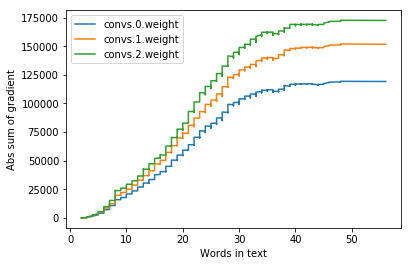

In [151]:
gradient_data.plot(y=conv_colums, x='lengths')
plt.xlabel('Words in text')
plt.ylabel('Abs sum of gradient')

In the previous graph we have the sum of gradients of each review, compared to the length of the text. We can see (obviously) that the longer texts have bigger gradients.

Let's concentrate to a subset of texts with length of 8.

In [159]:
data_subset = gradient_data[conv_colums + ['lengths']][gradient_data.lengths == 8]
data_subset.head()

,convs.0.weight,convs.1.weight,convs.2.weight,lengths
196,10763.613281,12515.798828,15261.559570,8
197,10763.640625,12515.749023,15261.550781,8
198,10764.854492,12515.544922,15261.535156,8
199,10808.764648,12764.723633,15232.453125,8
200,10818.828125,12858.488281,15196.083008,8


We can see that for exemple, the sum of gradient of text 200 is bigger than 196. How does these two texts look like? 

In [160]:
text_data.iloc[196][text_data.columns.drop(range(8,56))]

0                   a
1         masterpiece
2                four
3               years
4                  in
5                 the
6              making
7                   .
pred                0
labels              0
Name: 196, dtype: object

In [161]:
text_data.iloc[200][text_data.columns.drop(range(8,56))]

0            she
1           must
2           have
3              a
4           very
5         strong
6           back
7              .
pred           2
labels         0
Name: 200, dtype: object

When looking only the textual information, it is difficult to see, why are these two texts producing different gradients.

The model is predicting correctly the label for text 196 but it makes error with text 200. So as the backpropagation starts from the error of classification, it is logic that bad classified example (200) has bigger gradient.

Studying gradients was interesting, but it is more useful for understanding the learning phase. Our goal is to study the quality of our already learned model.

## Forward activations
Let's check, what three-word long trigrammes are activating most the convolution filters. By "maximum activation" I mean the maximum absolute value of activation.

I will concentrate to one convolutional layer (size 3) and I will look, what words multiplied by the convolution filters are most significants. In this layer I have 100 filter, so the output contains 100 convolutions for each window. I will sum up the results of these 100 filter's convolutions.

$$ output \in (batch\_size, C_{out}, seq\_length, seq\_dim) $$

$$ batch\_size := 1 $$

$$ seq\_dim := 1 $$

$$ output =  \sum_{C_{out}}^{f} output_f $$

$$ output \in (seq\_length) $$

So the each value in $ output $ is an activation of one window of three words.

In [76]:
activation_sums = []
lengths = []
all_texts = []
def study_convolutions(module, input, output):
    with torch.no_grad():
        activation_sums.append(output[:].sum(dim=1).squeeze(0).squeeze(1).cpu().numpy())

# study only convolution with filter length 3
handle = model.convs[0].register_forward_hook(study_convolutions)

try:
    for batch_i, (x,y) in enumerate(test_iter_individuel):
        nx = add_padding(x, pad_size=56)
        model(nn_embeddings(nx))
except Exception as e:
    print(e)
    handle.remove() # remove hook if error
handle.remove() # remove hook anyway


So let's plot these activations alongside of corresponding words.

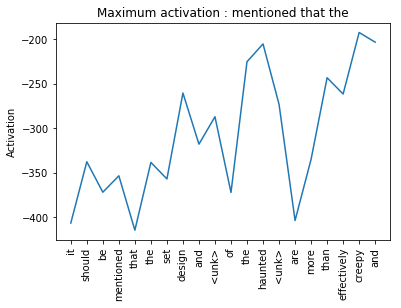

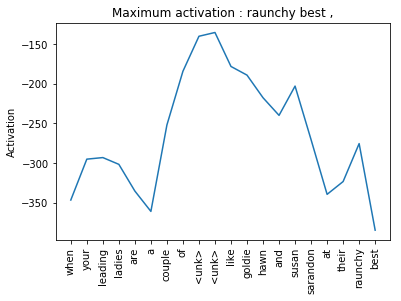

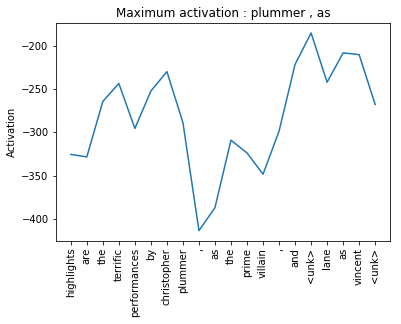

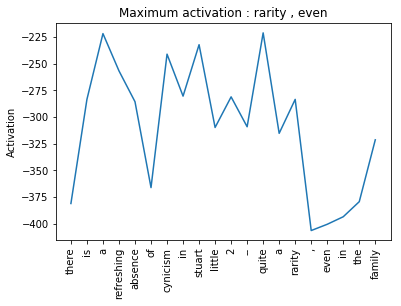

In [192]:
def neighbors(idx):
    if idx == 0:
        return np.arange(3)
    return [idx-1,idx,idx+1]

for _ in range(4):
    plt.figure()
    
    i = np.random.randint(0, len(all_texts))

    words_n = 20 # visualize only n first word in review.

    act = np.array(activation_sums)
    act = act.reshape(act.shape[0],act.shape[1])
    activations = pd.DataFrame(act)
    activations.iloc[i][:words_n].transpose().plot()
    plt.xticks(np.arange(words_n),text_data.iloc[i], rotation=90);
    
    max_activation = " ".join([text_data.iloc[i][j] for j in neighbors(activations.iloc[i].idxmin())])
    plt.title("Maximum activation : " + max_activation)
    plt.ylabel('Activation')

According these four random examples, the unknown words (and padding in the end of the reviews smaller than 56 words) are the activations near 0, so they are less important. The more the activation is negative, the more it contributes to classification. Let's iterate all exemples and search the maximum activations for kernel size 3.

In [175]:
trigrams = [[text_data.iloc[i][j] for j in neighbors(activations.iloc[i].idxmin())] for i in range(activations.shape[0])]
trigrams = pd.DataFrame(trigrams)
trigrams['labels'] = text_data['labels']
print(trigrams.head())
print("Number of distinct trigrams " + 
      str(np.unique(trigrams.drop(columns='labels').apply(" ".join, axis=1)).shape[0]) + " of " + str(trigrams.shape[0]))

             0  1      2  labels
0      hopkins  .  <unk>       2
1        <unk>  .  <unk>       2
2          no.  .  <unk>       1
3  immediately  .  <unk>       2
4   ridiculous  .  <unk>       1
Number of distinct trigrams 2005 of 2210


As most of trigrams are unique, let's visualize individual words of those trigrams.

In [191]:
label_names = ['positive', 'neutral', 'negative']
print("Most common words in maximum activations (filter size 3) in descending order")
for label in range(3):
    print(label_names[label].upper())
    
    c = Counter(np.concatenate(trigrams[trigrams.labels == label].drop(columns='labels').values))
    print(np.array(c.most_common(12))[:,0])

Most common words in maximum activations (filter size 3) in descending order
POSITIVE
[',' 'the' 'of' 'and' 'it' '<unk>' "'s" 'to' 'that' 'is' 'but' 'film']
NEUTRAL
[',' 'the' 'it' 'of' '<unk>' 'and' "'s" 'to' 'that' 'is' 'in' 'but']
NEGATIVE
[',' 'it' 'the' '<unk>' 'but' 'to' 'of' "'s" 'that' 'is' 'and' 'film']


We can see, that in the most common activations (filter size 3), the most common words are quite same for positive, negative and neutral classes. The word "but" is a little bit more often present in the maximum activation for class negative, than others. So word "but" is a feature that our convolutions extract and that could be used in classification, as it's distribution is different between classes.

# Gradients in the respect of input texts
(This part is added later)

Let's use the saliency maps to visualize, which part of the input text we should modify to minimise the error. The idea explainded in:

Simonyan, Karen, Andrea Vedaldi, and Andrew Zisserman. "Deep inside convolutional networks: Visualising image classification models and saliency maps." arXiv preprint arXiv:1312.6034 (2013).

Calculate saliency map w like
$ w_i = \frac{\partial y_i}{\partial x}$
where $y_i$ is a predicted class of x and x is a input text.

As each word in x is 100-dimensional, take mean of 100 gradients to be able to visualize word by word.

In [133]:
from torch.autograd import Variable

def compute_saliency_maps(X, y, model):
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y)
    
    y_pred = model(X_var)

    l = y_pred[np.arange(y_var.shape[0]), y_var].sum()
    l.backward()
    
    absolute = X_var.grad.abs()
    abs_mean = absolute.mean(dim=2)
    abs_max, _ = absolute.max(dim=2)
    return (abs_mean, abs_max, y_pred.argmax(1))

torch.Size([10, 58, 100])


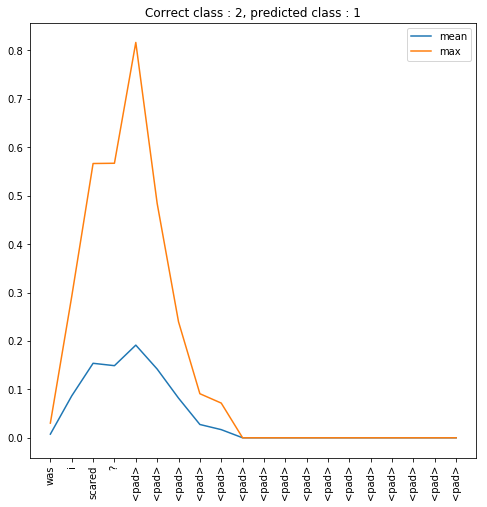

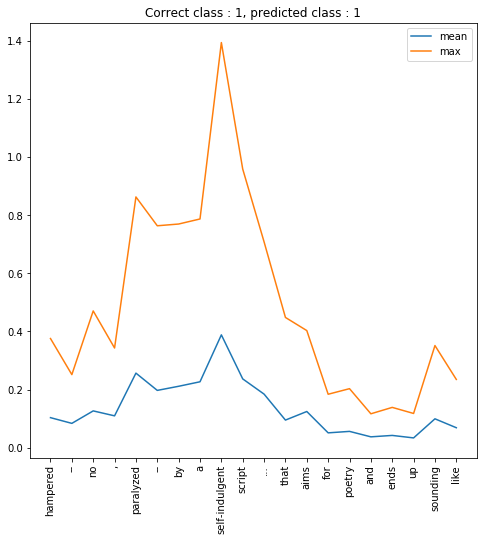

In [135]:
DIM_SIZE = TEXT.vocab.vectors.shape[1]
model = SentimentConv(filter_N=100,kernels=[3,4,5],embedding_dim=DIM_SIZE, outputs=3).to(device=device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

for param in model.parameters():
    param.requires_grad = False

for text,label in train_iter:
        
    nx = add_padding(text, pad_size=58)
    X = nn_embeddings(nx)
    texts = [[TEXT.vocab.itos[i] for i in nx[j,:].cpu().numpy()] for j in range(nx.shape[0])]

    saliency_mean, saliency_max, y_pred = compute_saliency_maps(X, label, model)
    print(X.shape)
    for i in range(X.shape[0]):
        if i < 2:
            words = 20
            text = texts[i]
            sal_mean = saliency_mean[i].cpu().numpy()[:words]
            sal_max = saliency_max[i].cpu().numpy()[:words]
            
            
            plt.figure(figsize=(8,8))
            plt.plot(np.arange(words),sal_mean, label="mean")
            plt.plot(np.arange(words),sal_max, label="max")
            plt.xticks(np.arange(words),text, rotation=90);
            plt.title("Correct class : {}, predicted class : {}".format(label[i], y_pred[i]))
            plt.legend()
    break;

These two examples shows, how our model would like to modify the input to better classify. The first text is incorrectly classified (model thinks it's neutral when it is negative) and the largest gradients are right after the padding starts : our model wants to insert more information, one could think. In the second example, the word "self-induigent script" is producing the biggest gradient. It might be a special word, that the kernels are pointing from the input, but which does not usually belong to this class (neutral).

Saliency maps are interesting, but we have to keep in mind that by modifying the words with biggest gradients, the input text might not make sense any more.

# Conclusion

- Parallel model is as good as sequential one, or better. The accuracy 0.62.
- Gradients of well classified examples are smaller.
- We can find some interesting trigrams, that activates the convolutions. For example the ones with 'but'
- Saliency maps shows, what are words or parts of input that the model wants to change to do better.